# CASC playground notebook + paper notes

## Summary

we can use node covariates to cluster better. We can get an upper bound on misclustering rate with a joint mixture model. Casc is usually better than both normal spectral clustering and canonical correlation analysis.

## Introduction

studying relationships in structured data is important.

A common approach to this is to find clusters in structured data.

Common methods to finding node clusters include bayesian, MLE, and spectral approaches. MLE is more interpretable, spectral is usually more accurate for sparse graphs and is computationally feasible for large graphs, bayesian is most flexible.

Nodes are also associated with additional measurements a lot of the time (age if the nodes are people, for instance). We can use these measurements to cluster better. They also help hella for interpreting clusters.

This is not a new idea, but most older methods don't provide any statistical guarantees. Bayesian methods eat categorical data and are computationally expensive. Other methods are kinda random and do a bunch of stuff, but don't give statistical guarantees. This paper gives the first one, as far as we can tell.

this work is a spectral approach, but it's better. Assortive CASC can do this by adding the covariance matrix of the node covariates to the regularized graph Laplacian. CASC uses the square of the regularized graph Laplacian, which is more general. It also uses a tuning parameter to balance out the contribution of the Laplacian and the covariance matrix in determining clustering.

We get the statistical guarantee by defining the node-contextualized sbm, which combines the sbm with a block-mixture model for node covariates. From this we can get a bound on casc's misclustering rate.

Canonical correlation analysis is worse than casc (if covariates are Bernoulli), but it's faster and doesn't require tuning. Our tuning parameter can have a reasonable default value though (e.g., the within-cluster sum-of-squares).

## Methodology

In [3]:
from graspologic.embed import CovariateAssistedSpectralEmbed

In [1]:
# gonna do this in code as I read

import numpy as np
import graspologic as gs
from graspologic.simulations import sbm
from graspologic.plot import heatmap
import pandas as pd
import matplotlib.pyplot as plt

array([[0.        , 0.00170773, 0.00171938, 0.00170918, 0.00170918],
       [0.00170773, 0.        , 0.00169895, 0.00168887, 0.00168887],
       [0.00171938, 0.00169895, 0.        , 0.00170038, 0.00170038],
       [0.00170918, 0.00168887, 0.00170038, 0.        , 0.00169029],
       [0.00170918, 0.00168887, 0.00170038, 0.00169029, 0.        ]])

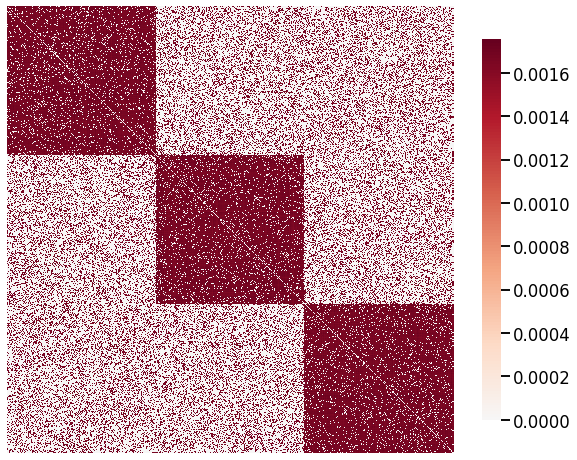

In [12]:
n = 200
n_communities = 3
p, q = .9, .3
B = np.array([[p, q, q], 
              [q, p, q],
              [q, q, p]])

B2 = np.array([[q, p, p], 
               [p, q, p],
               [p, p, q]])

A, labels = sbm([n, n, n], B, return_labels=True)
N = A.shape[0]
L = gs.utils.to_laplace(A, form='R-DAD')

heatmap(L)
L[:5, :5]

In [3]:
d = A.sum(axis=0)
tau = (1/A.shape[0]) * np.sum(d)

D = np.diag(1/np.sqrt(d + tau))
(D @ A @ D)[:5, :5]

array([[0.        , 0.00166813, 0.00166131, 0.00167365, 0.00170355],
       [0.00166813, 0.        , 0.00163929, 0.00165146, 0.00168097],
       [0.00166131, 0.00163929, 0.        , 0.00164471, 0.00167409],
       [0.00167365, 0.00165146, 0.00164471, 0.        , 0.00168653],
       [0.00170355, 0.00168097, 0.00167409, 0.00168653, 0.        ]])

In [4]:
L[:5, :5]

array([[0.        , 0.00166813, 0.00166131, 0.00167365, 0.00170355],
       [0.00166813, 0.        , 0.00163929, 0.00165146, 0.00168097],
       [0.00166131, 0.00163929, 0.        , 0.00164471, 0.00167409],
       [0.00167365, 0.00165146, 0.00164471, 0.        , 0.00168653],
       [0.00170355, 0.00168097, 0.00167409, 0.00168653, 0.        ]])

#### covariate matrix

each node has bounded covariate vector $X_i \in [-J,J]^R$  
$X \in [-J, J]^{N \times R}$ is the covariate matrix where each row corresponds to a node covariate vector

In [5]:
# generate a reasonable covariate matrix for A.
# in the kth block, the probability of the kth covariate being 1 is m1
# and the probability of the other covariates being 1 is m2
m1 = .9
m2 = .1

M = np.array([[m1, m2, m2],
              [m2, m1, m2],
              [m2, m2, m1]])

# Generate X

# for node i in community k,
# create an array of size n_communities,
# where the kth element of the array is 1 with probability m1,
# and every other element is 1 with probability m2.
# TODO: implement in pure numpy without loops. use scipy.stats.bernoulli.rvs?
n_communities = 3
X = []
for i, _ in enumerate(A):  # A is a 2d array, shape (30, 30)
    Xi = []
    k = labels[i]  # labels is an array of length 30
    for ii in range(n_communities):
        p = M[k, ii]
        Xi.append(np.random.choice([1, 0], p=[p, 1-p]))
    X.append(Xi)
X = np.array(X)
X[:5, :]

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

Assortive covariate-assisted spectral clustering:
- uses leading eigenvectors of $\bar{L}(\alpha) = L_{\tau} + aXX^T$, where X is a covariate matrix

<AxesSubplot:>

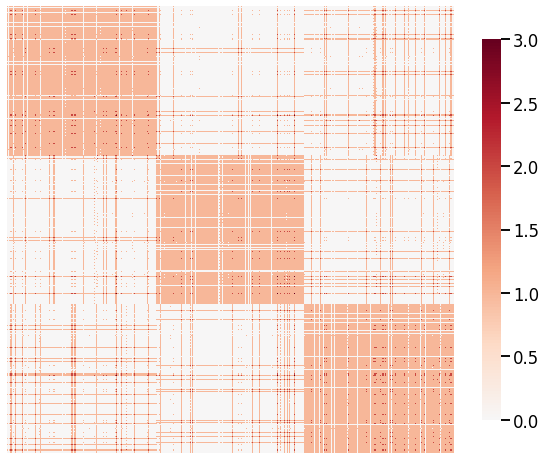

In [6]:
heatmap(X @ X.T)

<AxesSubplot:>

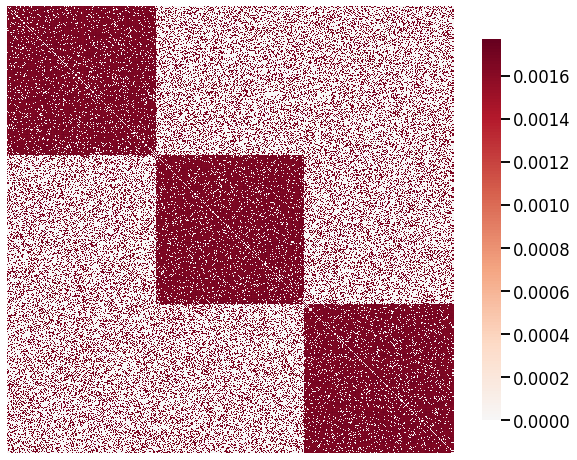

In [7]:
heatmap(L)

#### Assortive covariate-assisted spectral clustering

Uses leading eigenvectors of Lbar, with $\alpha$ being a tuning parameter.

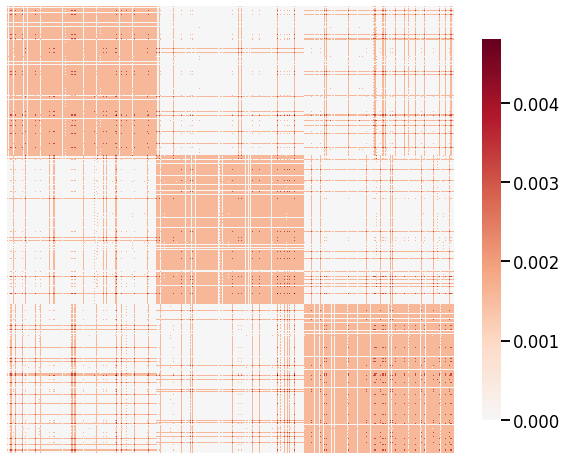

In [9]:
a = .0016
covs = (a*(X@X.T))

heatmap(covs)
plt.savefig("../figs/covs.png", dpi=300, bbox_inches='tight')

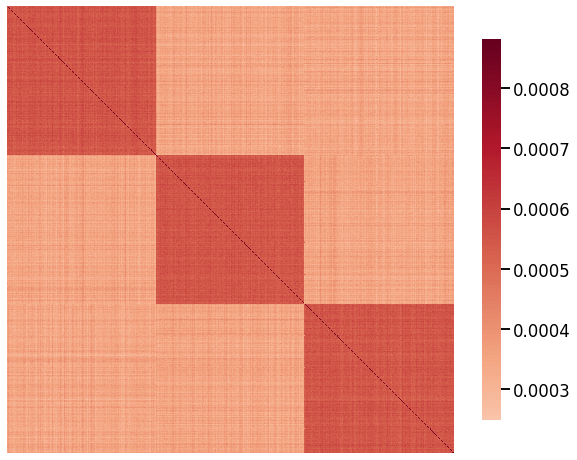

In [10]:
heatmap(L@L)
plt.savefig("../figs/L^2.png", dpi=300, bbox_inches='tight')

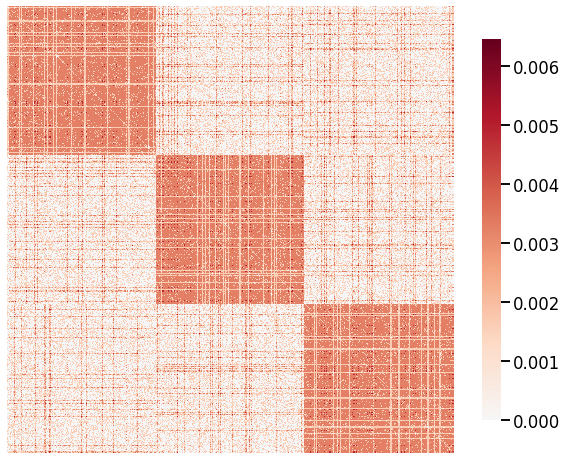

In [8]:
a = .0016  # determined empirically from "setting the tuning parameter"
L_bar = L + (a*(X@X.T))
heatmap(L_bar)
plt.savefig("../figs/Lbar.png", bbox_inches='tight', dpi=300)

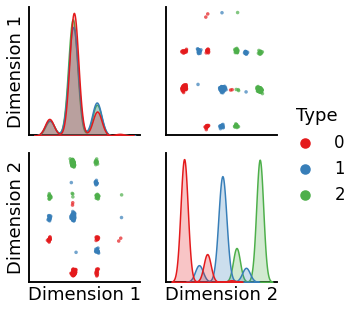

In [9]:
from graspologic.embed.svd import selectSVD
from graspologic.plot import pairplot

U, D, V = selectSVD(L_bar, n_components=2)
pairplot(U, labels=labels)

#### Covariate-assested spectral clustering

$\tilde{L_{\tau}} = L_{\tau}^2 + aXX^T$

In [10]:
L_tilde = (L@L) + a*(X@X.T)

In [11]:
L[:5, :5]

array([[0.        , 0.00164544, 0.00168949, 0.00166208, 0.00165231],
       [0.00164544, 0.        , 0.        , 0.00167719, 0.00166733],
       [0.00168949, 0.        , 0.        , 0.00172209, 0.00171197],
       [0.00166208, 0.00167719, 0.00172209, 0.        , 0.00168419],
       [0.00165231, 0.00166733, 0.00171197, 0.00168419, 0.        ]])

In [12]:
(L@L)[:5, :5]

array([[0.0008559 , 0.00053855, 0.00055869, 0.00055287, 0.00056823],
       [0.00053855, 0.00084008, 0.00051517, 0.00051528, 0.00054532],
       [0.00055869, 0.00051517, 0.00079535, 0.00050023, 0.00052866],
       [0.00055287, 0.00051528, 0.00050023, 0.00082344, 0.0005483 ],
       [0.00056823, 0.00054532, 0.00052866, 0.0005483 , 0.00083296]])

In [13]:
(X@X.T)

array([[1, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 2, 2],
       [1, 0, 0, ..., 1, 2, 2]])

In [14]:
L_tilde[:5, :5]

array([[0.0024559 , 0.00053855, 0.00055869, 0.00215287, 0.00216823],
       [0.00053855, 0.00084008, 0.00051517, 0.00051528, 0.00054532],
       [0.00055869, 0.00051517, 0.00079535, 0.00050023, 0.00052866],
       [0.00215287, 0.00051528, 0.00050023, 0.00242344, 0.0021483 ],
       [0.00216823, 0.00054532, 0.00052866, 0.0021483 , 0.00243296]])

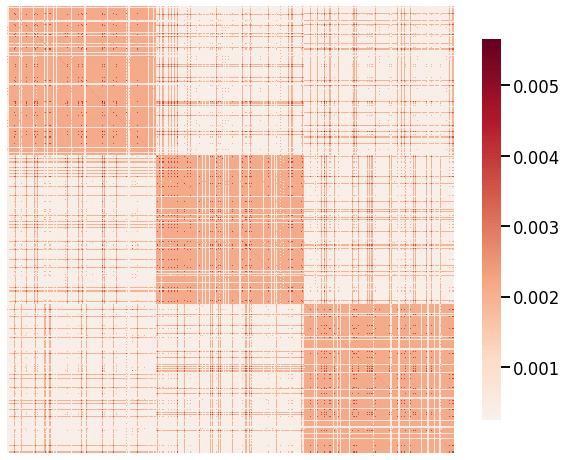

In [15]:
heatmap(L_tilde)
plt.savefig("../figs/Ltilde.png", bbox_inches='tight', dpi=300)

#### Setting the tuning parameter

"A good initial choice of $\alpha$ is the value which makes the leading eigenvalues of $L_{\tau} L_{\tau}$ equal, namely $\alpha_0 = \lambda_1(L_{\tau} L_{\tau})/\lambda_1(XX^T)$"  
"The tuning parameter $\alpha \in [\alpha_{min}, \alpha_{max}]$ is the value which minimizes the k-means objective function, the within-cluster sum-of-squares,  

$\Phi(\alpha) = \sum_{i=1}^K \sum_{u_j \in F_i} ||u_j(\alpha) - C_i(\alpha)||^2$ where $u_j$ is the jth row of $U$, $C_i$ is the centroid of the ith cluster from k-means clustering, and $F_i$ is the set of points in the ith cluster. Hence, the tuning parameter is $\alpha = \min_{\alpha \in [\alpha_{min}, \alpha_{max}]} \Phi(\alpha)$

In [16]:
# choose an alpha that makes the leading eigenvalues of LL and aXX^t equal
_, LL_eigs, _ = selectSVD(L@L, n_components=2)
_, XX_eigs, _ = selectSVD(a * X@X.T, n_components=2)  # a determined empirically/trial+error, don't understand the equation for a_0
4
XX_eigs

array([0.48126802, 0.29201079])

In [17]:
LL_eigs

array([0.25013578, 0.0403957 ])

## Simulations

In [18]:
B  # assortive

array([[0.9, 0.3, 0.3],
       [0.3, 0.9, 0.3],
       [0.3, 0.3, 0.9]])

In [19]:
B2  # non-assortive

array([[0.3, 0.9, 0.9],
       [0.9, 0.3, 0.9],
       [0.9, 0.9, 0.3]])

#### in the kth block, the probability of the kth covariate being 1 is m1, and the probability of the other covariates being 1 is m2

In [20]:
M  # covariance matrix for covariates

array([[0.9, 0.1, 0.1],
       [0.1, 0.9, 0.1],
       [0.1, 0.1, 0.9]])

- "since the brain graphs have heterogenous node degrees, the rows of the eigenvector matrix were normalized when applying the spectral clustering algorithm to improve clustering results (Qin and Rohe, 2013)"

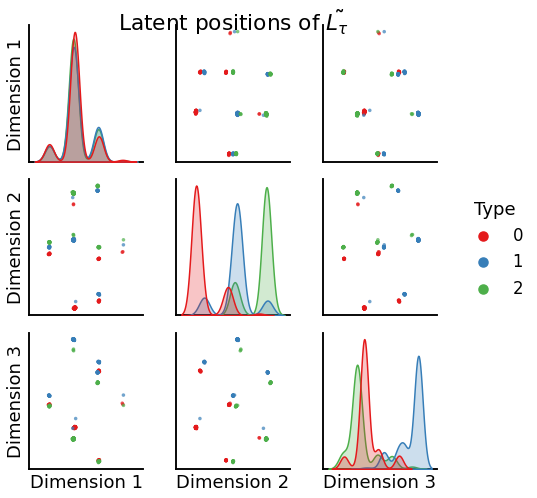

In [26]:
from graspologic.embed.base import BaseSpectralEmbed
from graspologic.utils import to_laplace
class CASC(BaseSpectralEmbed):
    def __init__(
        self,
        n_components=None,
        n_elbows=2,
        algorithm="randomized",
        n_iter=5,
        check_lcc=True,
        concat=False,
    ):
        self.n_components = n_components
        self.n_elbows = n_elbows
        self.algorithm = algorithm
        self.n_iter = n_iter
        self.check_lcc = check_lcc
        self.concat = concat

    def fit(self, graph, *, covariates=None, y=None):
        X = covariates
        L = to_laplace(A, form="R-DAD")
        a = self._get_tuning_param()
        Lt = L@L + (a*X@X.T)
        self._reduce_dim(Lt)
    
    def _get_tuning_param(self):
        return .0016  # TODO
        
    
casc = CASC(n_components=3)
casc.fit(A, covariates=X)
Xbar = casc.latent_left_
pairplot(Xbar, labels=labels, title=r"Latent positions of $\tilde{L_{\tau}}$")
plt.savefig("../figs/latent_positions")